## Classifier Performance Summary
#### Plot to summarise the performance of the different classifiers on BOSS DR12 data
In this notebook, we load the results from all of our classifiers on a subset of the BOSS DR12Q Superset, and compare the results. We look at performance vs redshift, R-band magnitude, and signal-to-noise ratio.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
  
import copy
import numpy as np
from matplotlib import pyplot as plt

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [2]:
figsize = (12,6.5)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [3]:
## RR parameters

## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True

## SQ parameters
p_min = 0.32
include_p_sq = True

In [4]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

## Load the RR data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_sdr12q_coadd.fits'
data['RR'] = utils.load_rr_data(f_rr)

## Load the DR12 pipeline data.
f_dr12pipe = variables.OUTDIR+'/results/dr12pipe_results/dr12pipe_sdr12q.fits'
data['PIPE'] = utils.load_rr_data(f_dr12pipe)

## Load the QN data.
f_qn = variables.OUTDIR+'/results/qn_results/qn_90pc.fits'
data['QN'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the SQ data.
f_sq = variables.OUTDIR+'/results/sq_results/sq_sdr12q.fits'
data['SQ'] = utils.load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)

In [6]:
for k in data.keys():
    print(k,len(data[k]))

RR 625167
PIPE 627751
QN 504534
SQ 545494


### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [7]:
data_table = utils.reduce_data_to_table(data,truth,include_c_qn=include_c_qn,include_p_sq=include_p_sq)
data_table[:5]

SPEC_ID,OBJ_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RR,CLASS_RR,ISQSO_RR,ZWARN_RR,Z_PIPE,CLASS_PIPE,ISQSO_PIPE,ZWARN_PIPE,Z_QN,CLASS_QN,ISQSO_QN,C_QN [6],Z_LINES_QN [6],Z_SQ,CLASS_SQ,ISQSO_SQ,P_SQ
int64,int64,int64,float64,str8,bool,float64,str8,bool,int64,float64,str8,bool,int64,float64,str8,bool,float64,float64,float64,str8,bool,float64
7166566020362,20589337,2,1.616,QSO,True,1.623,QSO,True,0,1.620,QSO,True,4,1.661,NONQSO,False,0.000 .. 0.000,2.159 .. 0.468,1.614,QSO,True,0.812
7166566020367,20603085,2,2.070,QSO,True,0.015,GALAXY,False,4,2.905,QSO,True,4,2.056,NONQSO,False,0.991 .. 0.000,2.056 .. 0.178,2.068,QSO,True,0.834
7169566280047,20935261,2,0.000,STAR,False,-0.000,STAR,False,0,-0.000,STAR,False,0,-0.062,NONQSO,False,0.000 .. 0.000,6.568 .. 0.169,-1.000,NONQSO,False,-1.000
7169566280046,20935742,2,0.000,STAR,False,-0.000,GALAXY,False,0,0.000,STAR,False,0,0.451,NONQSO,False,0.000 .. 0.000,2.909 .. 0.445,1.198,NONQSO,False,0.046
7169566280052,20936956,2,0.000,STAR,False,-0.001,GALAXY,False,0,-0.001,STAR,False,0,3.892,NONQSO,False,0.000 .. 0.000,5.291 .. -0.362,1.208,NONQSO,False,0.039


In [8]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
print('INFO: removed {}/{} spectra, {} left'.format((~w).sum(),len(w),len(data_table)))

INFO: removed 19232/500433 spectra, 481201 left


### Compare the performance of the classifiers.
We would like to show the performance of the different classifiers on a single dataset. We can show purity and completeness vs a range of different quantities.

In [9]:
data_table_archive = copy.deepcopy(data_table)

In [10]:
## Define general parameter values.
dv_max = 6000.

In [11]:
## Define strategies.
stratdefs = {}

# RR definitions.
c_kwargs = {'zwarn': False}
strat = strategy.Strategy('rr')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RR'] = {'isqso': pred.isqso, 'z': pred.z, 
                   'n': 'redrock', 'c': utils.colours['C0'], 'ls': '-'}

# PIPE definitions.
c_kwargs = {'zwarn': False}
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'PIPE'})
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['PIPE'] = {'isqso': pred.isqso, 'z': pred.z,
                     'n': 'DR12 Pipeline', 'c': utils.colours['C3'], 'ls': '--'}

# QN definitions.
c_kwargs = {'c_th': 0.5, 'n_detect': 1}
strat = strategy.Strategy('qn')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN'] = {'isqso': pred.isqso, 'z': pred.z, 'confs': data_table['C_QN'].data.max(axis=1),
                   'n': 'QuasarNET', 'c': utils.colours['C1'], 'ls': '-.'}

# SQ definitions.
c_kwargs = {'p_min': 0.32}
strat = strategy.Strategy('sq')
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['SQ'] = {'isqso': pred.isqso, 'z': pred.z, 'confs': data_table['P_SQ'],
                   'n': 'SQUEzE', 'c': utils.colours['C2'], 'ls': ':'}

#### Performance vs redshift

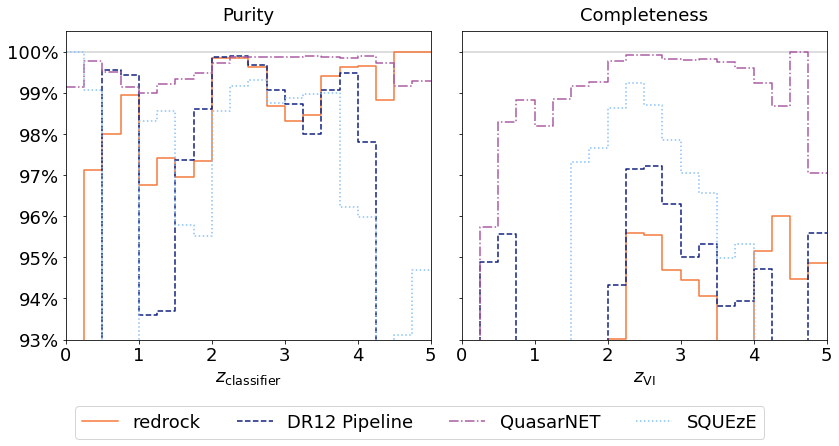

In [12]:
## Plot performance as a function of redshift for our strategies.
## Figure 1 of https://arxiv.org/abs/2007.10348
zmin,zmax = (0.,5.)
ymin,ymax = (0.93,1.005)
dz_int = 21
filename = '../plots/classifier_performance_summary_altcolour.pdf'

strategies = stratdefs
plot.plot_pur_com_vs_z(data_table,strategies,filename=filename,
                       zmin=zmin,zmax=zmax,dz_int=dz_int,dv_max=dv_max,
                       ymin=ymin,ymax=ymax,nydec=0,figsize=figsize)

plt.show()

In [34]:
isqso = data_table['ISQSO_VI']
highz = (data_table['Z_VI']>=2.1)
print(((~highz) & isqso).sum(),(highz & isqso).sum())

for s in strategies.keys():
    isqso_s = strategies[s]['isqso']
    z_s = strategies[s]['z']

    p,c = plot.get_pur_com(isqso_s,z_s,data_table['ISQSO_VI'],data_table['CLASS_VI']=='GALAXY',data_table['ZCONF_PERSON']==0,
        data_table['Z_VI'],zbin=(-10.,10.),dv_max=dv_max)
    p_lo,c_lo = plot.get_pur_com(isqso_s,z_s,data_table['ISQSO_VI'],data_table['CLASS_VI']=='GALAXY',data_table['ZCONF_PERSON']==0,
        data_table['Z_VI'],zbin=(-10.,2.1),dv_max=dv_max)
    p_hi,c_hi = plot.get_pur_com(isqso_s,z_s,data_table['ISQSO_VI'],data_table['CLASS_VI']=='GALAXY',data_table['ZCONF_PERSON']==0,
        data_table['Z_VI'],zbin=(2.1,10.),dv_max=dv_max)
    
    print(s)
    print(p,p_lo,p_hi)
    print(c,c_lo,c_hi)
    print(' ')


99006 172244
RR
0.9887030440349919 0.9774052478134111 0.9946484344083141
0.9132129032258065 0.8509383269700826 0.9490083834560274
 
PIPE
0.9866837712543065 0.9745934414630747 0.9934341257870669
0.9452092165898618 0.9125810556935944 0.963963911660203
 
QN
0.9964923410580516 0.9929975243773052 0.9985013592323242
0.9943188940092166 0.9870714906167303 0.9984847077401825
 
SQ
0.9647726053547712 0.9214127723182273 0.9898359507268375
0.9608073732718894 0.9214391047007252 0.983436288056478
 


### Performance vs c_th in two redshift bins

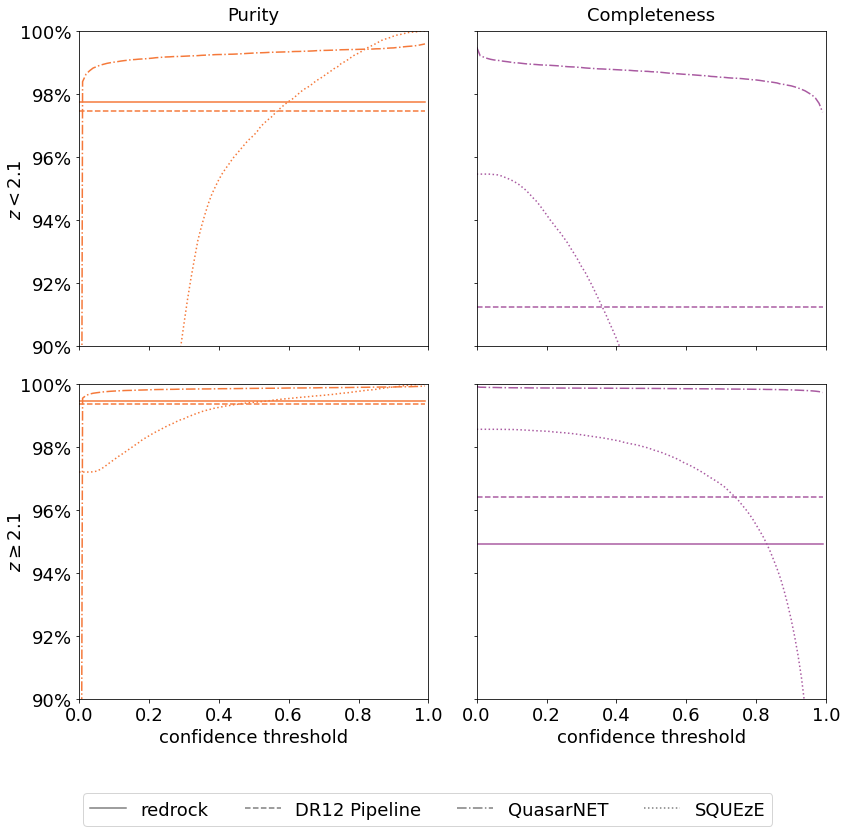

In [14]:
## Performance vs cth in two redshift bins
## Alternative way of representing same data as Figure 1 of https://arxiv.org/abs/2007.10348
zbins = [(None,2.1),(2.1,None)]
ymin = 0.9
ymax = 1.0
filename = '../plots/classifier_performance_summary_alt.pdf'

strategies = stratdefs
plot.plot_pur_com_vs_cth_zbin(data_table,strategies,filename=filename,
                         zbins=zbins,dv_max=dv_max,nydec=0,
                         figsize=(12,12),ymin=ymin,ymax=ymax)

plt.show()

In [15]:
## WIP

/global/u1/j/jfarr/.conda/envs/synthetic_lya_analysis/lib/python3.7/site-packages/astropy-4.2-py3.7-linux-x86_64.egg/astropy/table/column.py:1152: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


NameError: name 'isqso_c' is not defined

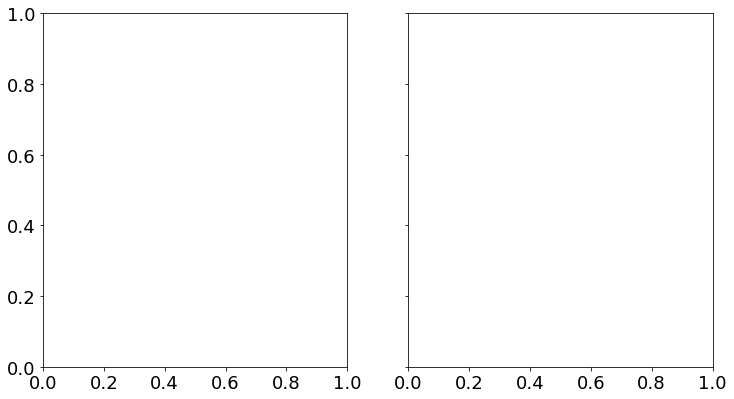

In [16]:
fig, axs = plt.subplots(1,2,figsize=(figsize[0],figsize[1]),sharex=True,sharey=True)

zlya = 2.1

cth_min = 0.0
cth_max = 1.0
n_int = 100
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))
ndetect = 1

isqso_truth = (data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2))
isgal_truth = (data_table['CLASS_VI']=='GALAXY')
isbad = ((data_table['ZCONF_PERSON']=='BAD') | (data_table['ZCONF_PERSON']!=2))
islya = (data_table['Z_VI']>=zlya)

for j,c in enumerate([k for k in data.keys() if k!='RR']):

    for i,wz in enumerate([~islya,islya]):
    
        tpr = []
        fpr = []
    
        z_c = data_table['Z_{}'.format(c)]
        zgood = (data_table['Z_VI']>-1) & (abs(z_c-data_table['Z_VI']) < dv_max*(1+data_table['Z_VI'])/300000.)

        for cth in c_th:
            if c=='QN':
                isqso_c = (data_table['CMAX_{}'.format(c)]>cth)>=ndetect
            elif c=='SQ':
                isqso_c = (data_table['P_{}'.format(c)]>cth)
            elif c=='RR':
                isqso_c = (data_table['ISQSO_{}'.format(c)])

            tp = (isqso_c & (isqso_truth | isgal_truth) & zgood & ~isbad & wz).sum()
            fp = (isqso_c & (~isbad) & wz).sum() - tp
            tn = (~isqso_c & (~isqso_truth) & wz).sum()
            fn = (~isqso_c & isqso_truth & wz).sum()
            
            tpr += [tp/(tp+fn)]
            fpr += [fp/(tn+fp)]
                   
        axs[i].plot(fpr,tpr,color=colours['C0'],ls=ls[c])

for i,wz in enumerate([~islya,islya]):
    isqso_rr = data_table['ISQSO_RR']
    tp = (isqso_rr & (isqso_truth | isgal_truth) & zgood & ~isbad & wz).sum()
    fp = (isqso_rr & (~isbad) & wz).sum() - tp
    tn = (~isqso_rr & (~isqso_truth) & wz).sum()
    fn = (~isqso_rr & isqso_truth & wz).sum()
    tpr = [tp/(tp+fn)]
    fpr = [fp/(tn+fp)]
    print(fp,tn)
    axs[i].scatter(fpr,tpr,color=colours['C0'],ls=ls[c],marker='X')

axs[0].set_title(r'$z_\mathrm{VI}<2.1$')
axs[1].set_title(r'$z_\mathrm{VI}\geq2.1$')

for ax in axs:
    #ax.set_xlim(0.,1.)
    #ax.set_ylim(0.,1.)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))
    ax.set_xlabel(r'false positive rate')

axs[0].set_ylabel(r'true positive rate')

artists = []
labels = []
for j,c in enumerate(data.keys()):
    artists += [axs[0].step([0],[0],where='pre',color='grey',ls=ls[c])[0]]
    labels += [legend_name[c]]

fig.legend(artists,labels,loc='lower center',borderaxespad=0,bbox_to_anchor=(0.5,0.03),ncol=len(artists))
rect = (0,0.13,1.,1.)
plt.tight_layout(rect=rect)
#plt.margins(x=0.1,y=0.1)

plt.savefig('../plots/classifier_performance_summary_alt2.pdf')
plt.show()